# Zobrazení souhrnných statistik

V tomto notebooku si ukážeme, jak zpracovat data, která jsme si uložili do formátu CSV v předchozím notebooku. Naučíme se, jak spočítat četnost jednotlivých sloupců v CSV tabulce a jak zjistit, který autor za daný rok se v databázi objevuje nejčastěji. <br>
Tento notebook je určený jak pro začátečníky, tak pro ty, kteří se chtějí seznámit se zpracováním dat v Pythonu.

## Předpoklady

Tento notebook nepředpokládá hluboké znalosti Pythonu, ale základní znalost programování bude užitečná.<br> 
Ukážeme si, jak načíst marcové soubory, jak procházet jejich záznamy, jak extrahovat potřebná data a jak je uložit do CSV a Excel souborů.

## Struktura notebooku

Notebook je rozdělen do několika částí:

0. **Příprava**: Přidáme potřebné knihovny, které budeme používat ke zpracování marcového souboru. 

1. **Načtení z CSV**: Ukážeme si, jak načíst naše data uložená v CSV.

2. **Souhrnné statistiky**: Naučíme se, jak z dat získat informace o nejčastějších autorech.

## Další zdroje

- [LearnPython.org](https://www.learnpython.org/): Tento online kurz nabízí výuku jazyka Python pro začátečníky i pokročilé. Může být užitečným zdrojem pro ty, kteří chtějí rozšířit své znalosti Pythonu.
- [W3Schools.com/Python](https://www.w3schools.com/python/): Obsáhlý tutoriál, který provází i některými oblíbenými knihovnamy Pythonu. 


### 0. Příprava 
Jako první si musíme nainstalovat knihovny, se kterými budeme pracovat. Knihovny jsou balíčky funkcí, které nejsou součástí základu jazyka python. <br>
Knihovny nainstalujeme pomocí příkazu `%pip install <jmeno_knihovny>` . Pak je do našeho notebooku přidáme pomocí příkazu `import <jmeno_knihovny> (as alias)`. K funkcím knihovny se pak přistupuje `jmeno_knihovny.jmeno_funkce` <br> 
Pokud z knihovny chceme využít pouze jednu funkci, přidáme ji pomocí `from <jmeno_knihovny> import <jmeno_funkce>`

In [12]:
# Prikaz ktery naistaluje knihovny
%pip install pandas 
%pip install numpy 

# Prikaz ktery knihovny prida 
from collections import Counter
import pandas as pd
import numpy as np

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Načtení z CSV

Nejprve pomocí knihovny pandas načteme naše uložená csv data do datové struktury DataFrame (která je podobná např. excelovské tabulce). Řádky v DataFramu reprezentují jednotlivé záznamy, sloupce pak jeden typ (např. jmeno autora).
Některá pole a podpole mohou opakovat, ty jsou  v csv spojené středníkem. V DataFramu pak funkcí `split()` hodnoty rozpojíme a převede do listu (seznamu). Pokud zrovna na daném místě žádná hodnota není, přidáme prázdný list.


In [13]:
# Cesta k nasim datum
csv_data = 'data/csv/out_cle.csv'

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')

print("Data načtena do DataFramu df.")

for column in df.columns:
    # Rok vydani bude vzdy jen jedenkrat
    if column != 'year': 
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])
              

Data načtena do DataFramu df.


### 2. Souhrnné statistiky

Nyní se podíváme, jak z dat zjistit jednoduché statistiky. 

#### 2.1 Počet výskytů 

Pokud chceme vědet, kolikrát se v databázi objevuje nějaká hodnota, použijeme funkci `value_counts()`. V následujícím příkladu si ukážeme, kolik je v databázi z jakého roku záznamů.<br>
Pomocí parametru `records_to_print` omezíme počet vypsaných záznamů na prvních x. Hodnoty se vypíší sestupně. 

In [14]:
records_to_print = 20

df['year'].value_counts()[:records_to_print] # vypise prvnich x zaznamu

year
1986    578
1987    564
1989    521
1985    519
1983    488
1988    476
1984    453
1981    423
1980    368
1982    366
1958    304
1979    298
1978    253
1959    227
1977    216
1975    212
1974    212
1976    211
1956    199
1972    187
Name: count, dtype: int64

Vidíme, že zdaleka nejvíce záznamů je z 80. let, následně pak z let 70. 

#### 2.2 Histogram

Počet výskytů také můžeme vykreslit pomocí histogramu. K tomu použijeme funkci `plot()`, která nám hodnoty vykreslí. <br> 
Pomocí parametru `kind` zvolíme typ zobrazení - histogram. Dále pomocí parametru `column` zvolíme data, která chceme zobrazit. Parametrem `bins` nastavíme počet sloupců.<br>
Funkce `plot()` má i další parametry. Jejich výčet můžete najít na [této](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) stránce.  


<Axes: title={'center': 'Počet záznamů'}, ylabel='Frequency'>

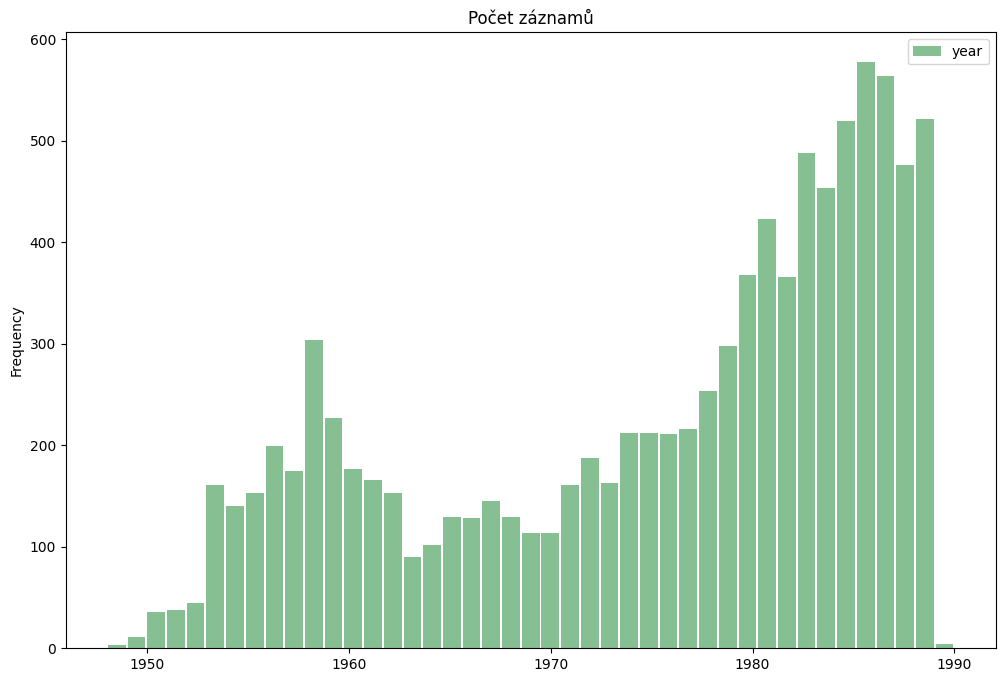

In [20]:
df.plot(kind = 'hist',column='year',  bins=len(df['year'].unique()), grid=False, figsize=(12,8), color='#86bf91', rwidth=0.9, title = "Počet záznamů za rok")

<div class='alert alert-block alert-info'>
    <b>Try It!</b> Místo sloupce 'year' můžeme vypsat např. 'author', čímž zjistíme, kolikrát se jaký autor v databázi objevuje.<br>
</div>

#### 2.3 Nejčastější autor v daném roce

Teď si ukážeme, jak z dat zjistit, který autor v jakém roce se v záznamech v daném roce nejčastěji objevuje jako autor. Existuje několik způsobů, jak na to přijít. My si představíme tři.<br>


##### 2.2.1 První varianta - value_counts

V naší první variantě využijeme funkci `value_counts()`, kterou jsme se už naučili. <br>

Abychom měli hezčí výpis, použijeme formátování. Předem si řekneme, v jakém formátu budeme chtít hodnoty vypsat a jak velké mezi nimi budou mezery.<br>
U některých záznamů je nejčetnější hodnota prázdný list (tedy autor v záznamech chybí).  Proto prázdné řádky pro tento příklad vyfiltrujeme. <br>
Pak budeme postupně procházet roky vydání záznamů. Z naší tabulky si vyselektujeme řádky s jedním rokem vydání. Na ně zavoláme funkci `value_counts()`. Funkce nám vrátí spočítané četnosti v sestupném pořadí, proto nám stačí vzít jen první hodnotu.<br>

<b>Následující kód funguje pouze pro sloupce, kde se hodnoty v jednom řádku neopakují. Reprezentují marcová pole, která se nemohou opakovat.</b>


In [4]:
# Vybereme sloupec, ktery chceme vypsat
picked_column = 'author'

# Formatovani pro hezci vypis
string = "{year: >25} {name: >25} {records: >25}"

# Nejcastejsi hodnoty vypiseme
print(string.format(year = "Rok", name = "Nejčastější autor", records = "Počet záznamů"))
print("----------------------------------------------------------------------------------------------------")

# Data ocistime o prazdne hodnoty
data_filtered = df[df[picked_column].apply(lambda x: len(x) > 0)]

for year in  np.unique(df['year']):
    if any(data_filtered[data_filtered['year'] == year]['author']):
        ret = data_filtered[data_filtered['year'] == year]['author'].value_counts() 
        s = string.format(year = year, name = ' '.join(ret.index[0]), records = str(ret.values[0])) 
        print(s)

                      Rok         Nejčastější autor             Počet záznamů
----------------------------------------------------------------------------------------------------
                     1948         Jandáček, Antonín                         1
                     1949         Dresler, Jaroslav                         1
                     1950             Demetz, Peter                         3
                     1951              Čapek, Karel                         2
                     1952             Demetz, Peter                         3
                     1953             Vlach, Robert                        17
                     1954             Vlach, Robert                         8
                     1955             Vlach, Robert                        13
                     1956            Želivan, Pavel                        11
                     1957             Vlach, Robert                         9
                     1958                

V tabulce vidíme, že počet napsaných článků za jednotlivé roky se výrazně liší. 

#### 2.2.2 Druhá varianta - groupby a Counter

V druhé variantě si ukážeme, jak data upravit pomocí funkcí `groupby()` a `Counter()` 

Tím, že máme data uložena do DataFramu, umožňuje nám to využít funkce knihovny pandas. V našem případě využijeme funkci `groupby()`, která data seskupí podle vybraného sloupce. <br>
Použijeme také funkci `Counter()`, která nám spočte výskyt každého elementu. V neposlední řadě využijeme funkci `lambda`.<br>

In [5]:
# Vybereme sloupec, ktery chceme vypsat
picked_column = 'author'

# Data ocistime o prazdne hodnoty
data_filtered = df[df[picked_column].apply(lambda x: len(x) > 0)]

# Data seskupime podle nejcastejsiho elementu v kazde hodnote groupby
most_common = data_filtered.groupby('year')[picked_column].apply(lambda x: Counter(element for elements in x for element in elements).most_common()[0] if len(x) > 0 else None) 

# Formatovani pro hezci vypis
string = "{year: >25} {name: >25} {records: >25}"
# Nejcastejsi hodnoty vypiseme
print(string.format(year = "Rok", name = "Nejčastější autor", records = "Počet záznamů"))
print("----------------------------------------------------------------------------------------------------")

for key, value in most_common.items():
    print(string.format(year = key, name = value[0], records = value[1]))        

                      Rok         Nejčastější autor             Počet záznamů
----------------------------------------------------------------------------------------------------
                     1948         Jandáček, Antonín                         1
                     1949         Dresler, Jaroslav                         1
                     1950             Demetz, Peter                         3
                     1951             Demetz, Peter                         2
                     1952           Peška, Vladimír                         3
                     1953             Vlach, Robert                        17
                     1954           Hostovský, Egon                         8
                     1955             Vlach, Robert                        13
                     1956            Želivan, Pavel                        11
                     1957             Vlach, Robert                         9
                     1958                

<div class='alert alert-block alert-info'>
    <b>Try It!</b> Kód je napsán tak, aby se parametry daly jednoduše upravit. Můžeme si tak zkusit změnit proměnnou picked_colum na 'figures', čímž zjistíme, o kom nejvíce se za daný rok psalo.
</div>

##### 2.2.1 Třetí varianta - vlastní funkce

Jako poslední variantu si algoritmy napíšeme sami. Implementujeme dvě funkce, které pak zavoláme. <br>

První funkce `count_years(df, column)` nám spočte počet článků každého autora v každém roce. Jako vstupy přijímá DataFrame `df` a vybraný sloupec `column`. Výsledky pak vrátí jako dictionary, kde klíčem je tuple (rok, jméno autora) a hodnota je počet článků.<br>
Druhá funkce `find_most_common(count)` pak pro každý rok zjistí, který autor v každém roce napsal nejvíce článků. Vstupem je dictionary `count`, který nám vrátí funkce `count_years(df, column)`. Funkce pak postupně projde všechny klíče dictionary `count` a pro každý rok si pamatuje autora s nejvyšším počtem záznamů. Funkce nakonec vrátí setřízený dictionary, kde klíč je rok a hodnota je tuple (jmeno autora, počet záznamů).   


In [6]:
# Funkce ktera nam spocte pocet zaznamu v danem roce pro kazdeho autora
def count_years(df, column):
    
    # Dictionary, ve kterem jako klic ulozime (rok, jmeno autora)
    # a jako hodnotu budeme pripocitavat pocet clanku
    count = {}
    
    # Projdeme radky DataFramu
    for _,row in df.iterrows():
        year = row['year']
        for element in row[column]:
            key = (year, element) 
            # Pokud klic jiz existuje, pripocteme jednicku
            if key in count.keys():
                count[key] += 1
            else:
                # Pokud klic zatim neexistuje, vytvorime ho a pridame jedna
                count[key] = 1  
    return count              

# Funkce, ktera nam najde nejcastejsiho autora v danem roce
def find_most_common(count):
    # Dictionary, ve kterem jako klic ulozime rok
    # a jako hodnotu (jmeno autora, pocet clanku)
    most_common = {}

    # Projdeme klice a hodnoty dictionary
    for key,value in count.items():
        year = key[0]
        # Pokud klic (rok) jiz existuje, podivame se, 
        # zda je pocet clanku u aktualniho autora vyssi  
        if year in most_common:
            if most_common[year][1] < value:
                # Pamatujeme si jen tu nejvyssi hodnotu
                most_common[year] = (key[1], value)    
        else:
            most_common[year] = (key[1], value) 
    
    #Klice slovniku seradime od nejmensiho cisla po nejvetsi         
    years = list(most_common.keys())
    years.sort()
    sorted_most_common = {i: most_common[i] for i in years}        
    return sorted_most_common            

print("Funkce uloženy.")
  

Funkce uloženy.


Teď už jen funkce zavoláme a výsledek vypíšeme. <br> 
Použijeme stejné formátování, které jsme si už napsali.  

In [7]:
# Vybereme sloupec, ktery chceme vypsat
picked_column = 'author'

# Zavolame nase funkce
count = count_years(df, picked_column)

most_common = find_most_common(count)

# Formatovani pro hezci vypis
string = "{year: >25} {name: >25} {records: >25}"

# Nejcastejsi hodnoty vypiseme
print(string.format(year = "Rok", name = "Nejčastější autor", records = "Počet záznamů"))
print("----------------------------------------------------------------------------------------------------")
for key, value in most_common.items():
    print(string.format(year = key, name = value[0], records = value[1]))        


                      Rok         Nejčastější autor             Počet záznamů
----------------------------------------------------------------------------------------------------
                     1948         Jandáček, Antonín                         1
                     1949         Dresler, Jaroslav                         1
                     1950             Demetz, Peter                         3
                     1951             Demetz, Peter                         2
                     1952           Peška, Vladimír                         3
                     1953             Vlach, Robert                        17
                     1954           Hostovský, Egon                         8
                     1955             Vlach, Robert                        13
                     1956            Želivan, Pavel                        11
                     1957             Vlach, Robert                         9
                     1958                

Je možné, že se od sebe budou tabulky mírně odlišovat a to v případě, že databáze za daný rok obsahuje více autorů se stejným počtem záznamů. 

<div class='alert alert-block alert-info'>
    <b>Try It!</b> Napadá vás ještě nějaký jiný způsob, jak zjistit nejčastějšího autora?
</div>


#### 2.3 Nejčastější autor v daném roce - opakované hodnoty

Jak jsme viděli, může stát, že četnost některých autorů za daný rok je stejná - tedy že rok obsahuje více autorů se stejným počtem záznamů, napíšeme si kód, v případě opakování vypíše všechny autory. <br>
Ukážeme si dvě varianty.

##### 2.3.1 První varianta - Counter

Napíšeme si funkci `max_counter(lst)`, která jako vstup bere list `lst`. Nejprve použijeme `Counter`, abychom spočítali počet výskytů jednotlivých prvků v listu. Poté najde maximální hodnotu počtu výskytů a vytvoří list těch prvků, které mají tento maximální počet výskytů. Funkce vrátí tento list prvků spolu s jejich počtem výskytů. <br>


In [8]:
def max_counter(lst):

    # Pomocí Counteru spočteme počty výskytů prvků ve všech vnořených listech
    counted_elements = Counter(element for elements in lst for element in elements)

    # Najdeme maximální hodnoty počtu výskytů
    max_val = max(counted_elements.values())

    # Vytvoříme list prvků s maximálním počtem výskytů a jejich počty výskytů
    ret = [(key, value) for key, value in counted_elements.items() if value == max_val]
    return ret

Projdeme unikátní roky v našich datech. Vyselektujeme ty řádky, kde se rok rovná. Naši připravenou funkci pak zavoláme na vyselektované řády. 

In [9]:

# Vybereme sloupec, ktery chceme vypsat
picked_column = 'author'

# Data ocistime o prazdne hodnoty
data_filtered = df[df[picked_column].apply(lambda x: len(x) > 0)]

# Formatovani pro hezci vypis
string = "{year: >25} {name: >25} {records: >25}"

# Nejcastejsi hodnoty vypiseme
print(string.format(year = "Rok", name = "Nejčastější autor", records = "Počet záznamů"))
print("----------------------------------------------------------------------------------------------------")

# Projdeme unikátní roky 
for year in np.unique(data_filtered['year']):

    # Zavoláme funkci  max_counter na vybraném sloupci dat pro konkrétní rok a získáme seznam nejčetnějších prvků
    ret = max_counter(data_filtered[data_filtered['year'] == year][picked_column])

    # Projdeme list nejčetnějších prvků pro daný rok
    for name, number_of_records in ret:    
        print(string.format(year = year, name = name, records = number_of_records))

                      Rok         Nejčastější autor             Počet záznamů
----------------------------------------------------------------------------------------------------
                     1948         Jandáček, Antonín                         1
                     1948           Martínek, Josef                         1
                     1948       Zázvorka, Břetislav                         1
                     1949         Dresler, Jaroslav                         1
                     1949             Brušák, Karel                         1
                     1949               Dyk, Viktor                         1
                     1949              Kohout, Jára                         1
                     1949       Peroutka, Ferdinand                         1
                     1949           Schwarz, Stefan                         1
                     1949  Štěrba, Francisco Carlos                         1
                     1949           Brouk

##### 2.3.1 Druhá varianta - úprava našich funkcí

Funkce `count_years(df, column)` a `find_most_common(count)` už máme napsané. V tomto příkladu jen trochu poupravíme funkci `find_most_common(count)` tak, abychom si v případě, že narazíme na autora se stejným počtem článků jaký už máme uložený, zapamatujeme obě jména.  

In [10]:
# Funkce ktera nam spocte pocet zaznamu v danem roce pro kazdeho autora
def count_years(df, column):
    
    # Dictionary, ve kterem jako klic ulozime (rok, jmeno autora)
    # a jako hodnotu budeme pripocitavat pocet clanku
    count = {}
    
    # Projdeme radky DataFramu
    for _,row in df.iterrows():
        year = row['year']
        for element in row[column]:
            key = (year, element) 
            # Pokud klic jiz existuje, pripocteme jednicku
            if key in count.keys():
                count[key] += 1
            else:
                # Pokud klic zatim neexistuje, vytvorime ho a pridame jedna
                count[key] = 1  
    return count              

# Funkce, ktera nam najde nejcastejsiho autora v danem roce
def find_most_common(count):
    # Dictionary, ve kterem jako klic ulozime rok
    # a jako hodnotu (jmeno autora, pocet clanku)
    most_common = {}

    # Projdeme klice a hodnoty dictionary
    for key,value in count.items():
        year = key[0]

        # Pokud klic (rok) jiz existuje
        if year in most_common:

            # Zkontrolujeme, zda je pocet clanku u aktualniho autora vyssi
            if most_common[year][0][1] < value:
                most_common[year] = [(key[1], value)]    
            
             # Pokud mají stejný počet článků, přidáme aktuálního autora do listu
            elif most_common[year][0][1] == value:
                most_common[year].append((key[1], value))  
        else:
            most_common[year] = [(key[1], value)] 
    
    #Klice slovniku seradime od nejmensiho cisla po nejvetsi         
    years = list(most_common.keys())
    years.sort()
    sorted_most_common = {i: most_common[i] for i in years}        
    return sorted_most_common            

print("Funkce uloženy.")

Funkce uloženy.


In [11]:
# Vybereme sloupec, ktery chceme vypsat
picked_column = 'author'

# Zavolame nase funkce
count = count_years(df, picked_column)

most_common = find_most_common(count)

# Formatovani pro hezci vypis
string = "{year: >25} {name: >25} {records: >25}"
# Nejcastejsi hodnoty vypiseme
print(string.format(year = "Rok", name = "Nejčastější autor", records = "Počet záznamů"))
print("----------------------------------------------------------------------------------------------------")
for key, value in most_common.items():
    for v in value:
        print(string.format(year = key, name = v[0], records = v[1]))  

                      Rok         Nejčastější autor             Počet záznamů
----------------------------------------------------------------------------------------------------
                     1948         Jandáček, Antonín                         1
                     1948           Martínek, Josef                         1
                     1948       Zázvorka, Břetislav                         1
                     1949         Dresler, Jaroslav                         1
                     1949             Brušák, Karel                         1
                     1949               Dyk, Viktor                         1
                     1949              Kohout, Jára                         1
                     1949       Peroutka, Ferdinand                         1
                     1949           Schwarz, Stefan                         1
                     1949  Štěrba, Francisco Carlos                         1
                     1949           Brouk

<div class='alert alert-block alert-info'>
    <b>Try It!</b> Kromě bibliografie literárního exilu můžeme vyzkoušet i jiné bibliografie. Stačí si v předchozím Jupyter notebooku vytvořit CSV tabulku. 
</div>
